## Precipitation extremes

In [1]:
import glob

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import geopandas as gp

import cmocean
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import spatial_selection
import plotting

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dask.diagnostics.ProgressBar().register()

In [4]:
start_date = '1960-01-01'
end_date = '1979-12-31'

In [5]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

In [6]:
def read_data(infile, regrid=False, mask=False, time_bounds=None):
    """Read data and calculate annual mean.
    
    Parameters
    ----------
    infile (str)
    regrid (xarray Dataset) - grid to remap to
    time_bounds (list)
    
    """
    
    ds = xr.open_dataset(infile, decode_timedelta=False)
    if time_bounds:
        start_date, end_date = time_bounds
        ds = ds.sel({'time': slice(start_date, end_date)})
    annual_mean = ds.mean('time', keep_attrs=True)
    if type(regrid) == xr.core.dataset.Dataset:
        regridder = xe.Regridder(ds, regrid, "bilinear")
        annual_mean = regridder(annual_mean)    
    annual_mean = spatial_selection.select_shapefile_regions(annual_mean, aus_shape)    
    annual_mean = annual_mean.compute()
    
    return annual_mean

In [7]:
def plot_index(var_name, index_name, data_levels, diff_levels, agcd_mask=None):
    """Plot a climate index"""

    index_name_lower = index_name.lower()
    infiles = {}
    infiles['AGCD'] = f'/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-r005/none/BOM-AGCD/historical/v1/none/none/climdex/{index_name_lower}/{index_name_lower}_AUS-r005_BOM-AGCD_historical_v1_year_190001-202112.nc'
    infiles['ACCESS-CM2'] = f'/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/GLOBAL-gn/none/CSIRO-ARCCSS-ACCESS-CM2/historical/r4i1p1f1/none/none/climdex/{index_name_lower}/{index_name_lower}_GLOBAL-gn_CSIRO-ARCCSS-ACCESS-CM2_historical_r4i1p1f1_year_185001-201412.nc'
    infiles['BARPA'] = f'/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/climdex/{index_name_lower}/{index_name_lower}_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_year_196001-197912.nc'

    annual_mean = {}
    annual_mean['AGCD'] = read_data(
        infiles['AGCD'], regrid=False, time_bounds=[start_date, end_date]
    )
    if type(agcd_mask) == xr.core.dataarray.DataArray:
        annual_mean['AGCD'][index_name] = annual_mean['AGCD'][index_name].where(agcd_mask)
    for model in ['ACCESS-CM2', 'BARPA']:
        annual_mean[model] = read_data(
            infiles[model], regrid=annual_mean['AGCD'], time_bounds=[start_date, end_date]
        )
    plotting.compare_agcd_gcm_rcm(
        annual_mean['AGCD'][index_name],
        annual_mean['ACCESS-CM2'][index_name],
        var_name,
        index_name_lower,
        'ACCESS-CM2',
        'BARPA',
        start_date,
        end_date,
        data_levels,
        diff_levels,
        rcm_da=annual_mean['BARPA'][index_name],
    )

## Mask

The AGCD dataset comes with `precip_weights` data for the v1 daily precipitation data. At each individual timestep each grid cell gets a value of 0, 1 or 3.

File metadata explaining the weights:
- "Weight indicating relative contribution of station data to analysis"
- "The amount of influence that nearby station measurements have on a grid point, set to 0 when a grid point has not been changed from its base climatology by nearby station measurements."

It looks like it's preferable to only keep grid points that get a 3 at all or close to all times.

In [8]:
weight_files = glob.glob('/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_19[6,7]*.nc')
weight_files.sort()
print(weight_files)

['/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1960.nc', '/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1961.nc', '/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1962.nc', '/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1963.nc', '/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1964.nc', '/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1965.nc', '/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1966.nc', '/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1967.nc', '/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1968.nc', '/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1969.nc', '/g/data/zv2/agcd/v1/precip/weight/r005/01day/agcd_v1_precip_weight_r005_daily_1970.nc', '/g/data/zv2/agcd/v1

In [9]:
ds_weight = xr.open_mfdataset(weight_files)
count = (ds_weight['weight'] > 1.0).sum('time', keep_attrs=True)
fraction = count / len(ds_weight['time'])
da_mask = fraction > 0.9  

## rx1day

[########################################] | 100% Completed |  1min 11.3s
[########################################] | 100% Completed |  1min  9.8s
[########################################] | 100% Completed |  1min  9.8s
/g/data/xv83/dbi599/model-evaluation/pr_rx1day_BARPA-ACCESS-CM2_1960-01-01_1979-12-31.png


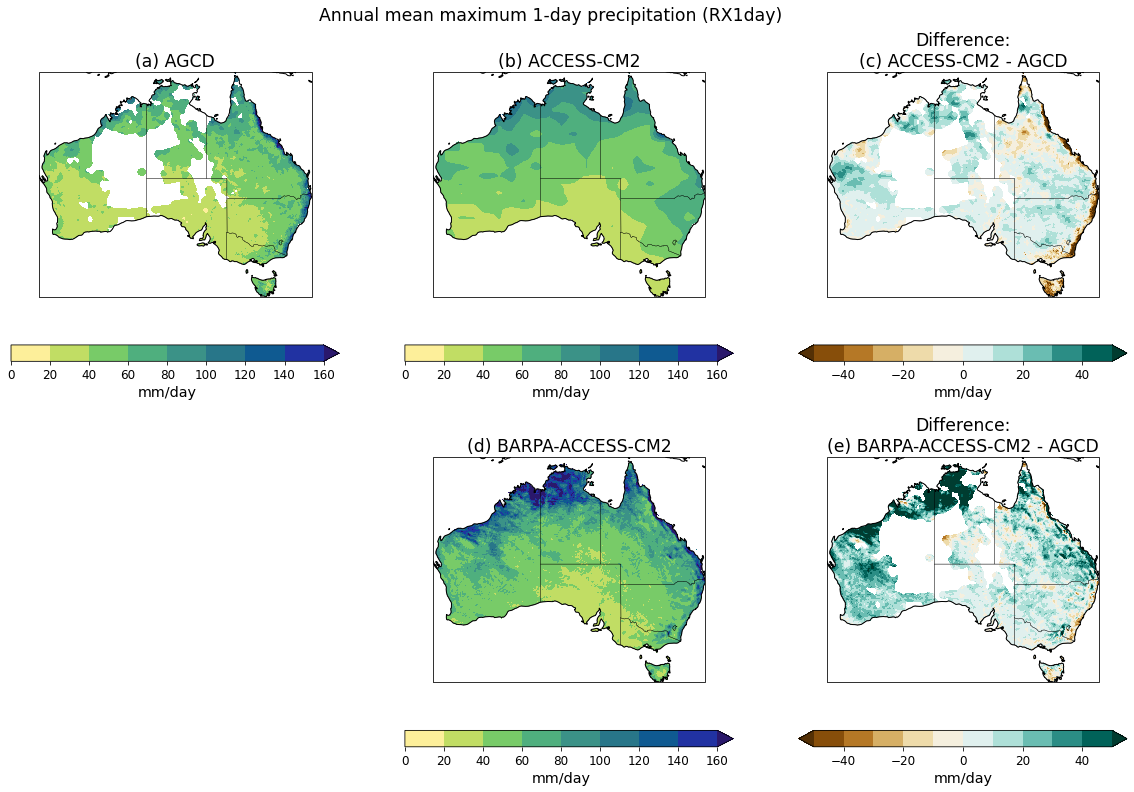

In [10]:
plot_index(
    'pr',
    'RX1day',
    [0, 20, 40, 60, 80, 100, 120, 140, 160],
    [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50],
    agcd_mask=da_mask,
)

## r10mm - Number of heavy precipitation days (>10mm)

[########################################] | 100% Completed |  1min 10.8s
[########################################] | 100% Completed |  1min 10.3s
[########################################] | 100% Completed |  1min 10.0s
/g/data/xv83/dbi599/model-evaluation/pr_r10mm_BARPA-ACCESS-CM2_1960-01-01_1979-12-31.png


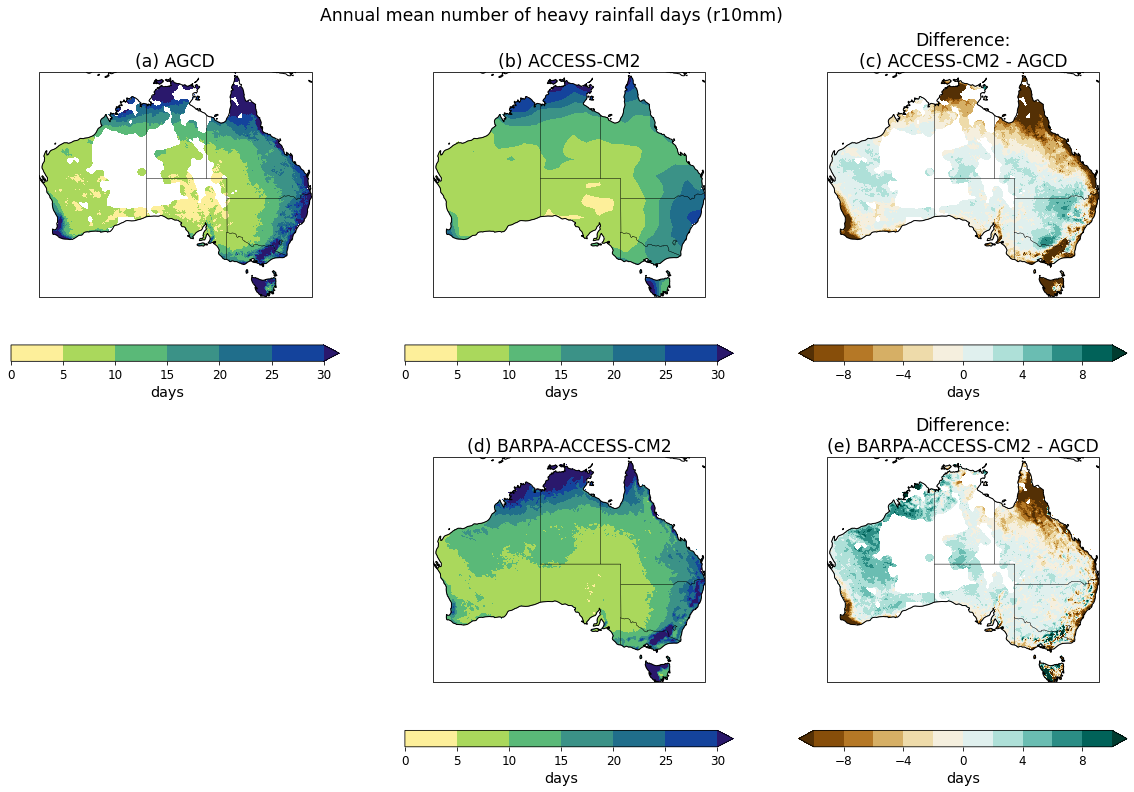

In [11]:
plot_index(
    'pr',
    'R10mm',
    [0, 5, 10, 15, 20, 25, 30],
    [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10],
    agcd_mask=da_mask,
)

## CDD - Maximum consecutive dry days (< 1mm)

[########################################] | 100% Completed |  1min 10.5s
[########################################] | 100% Completed |  1min  9.5s
[########################################] | 100% Completed |  1min  9.3s
/g/data/xv83/dbi599/model-evaluation/pr_cdd_BARPA-ACCESS-CM2_1960-01-01_1979-12-31.png


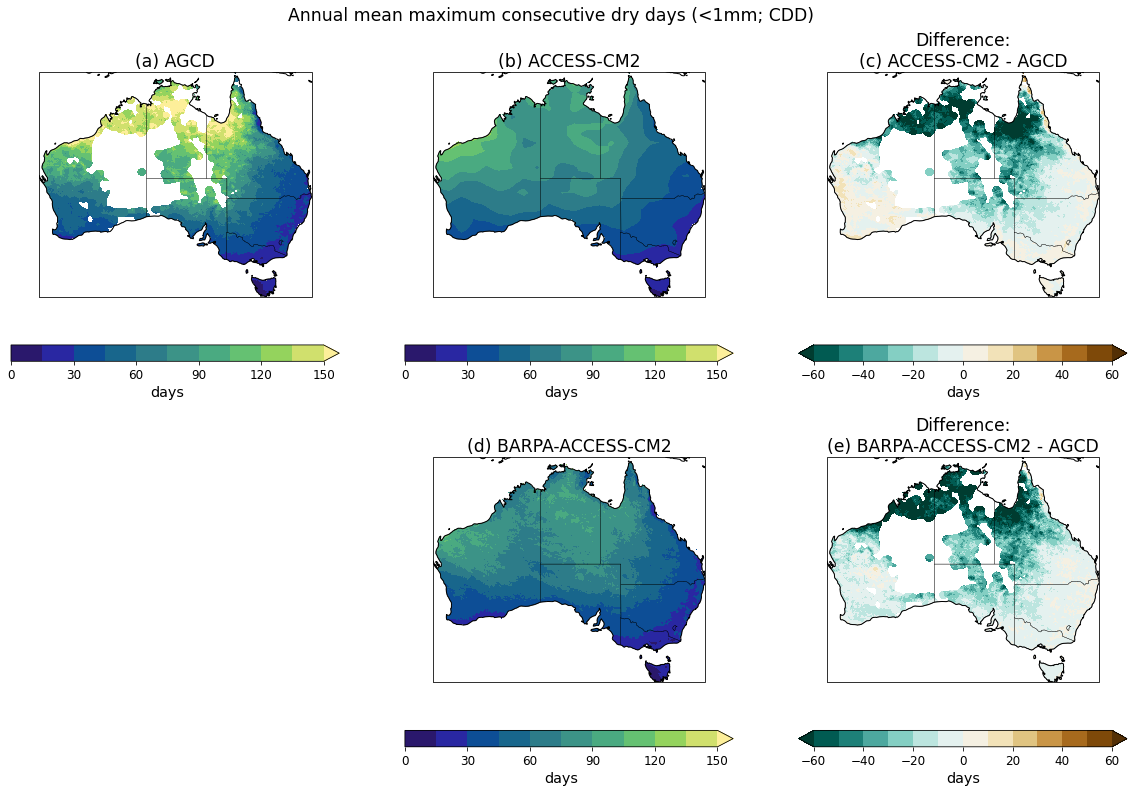

In [12]:
plot_index(
    'pr',
    'CDD',
    [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150],
    [-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60],
    agcd_mask=da_mask,
)

## CWD - Maximum consecutive wet days (>1mm)

[########################################] | 100% Completed |  1min  9.8s
[########################################] | 100% Completed |  1min  9.5s
[########################################] | 100% Completed |  1min  9.4s
/g/data/xv83/dbi599/model-evaluation/pr_cwd_BARPA-ACCESS-CM2_1960-01-01_1979-12-31.png


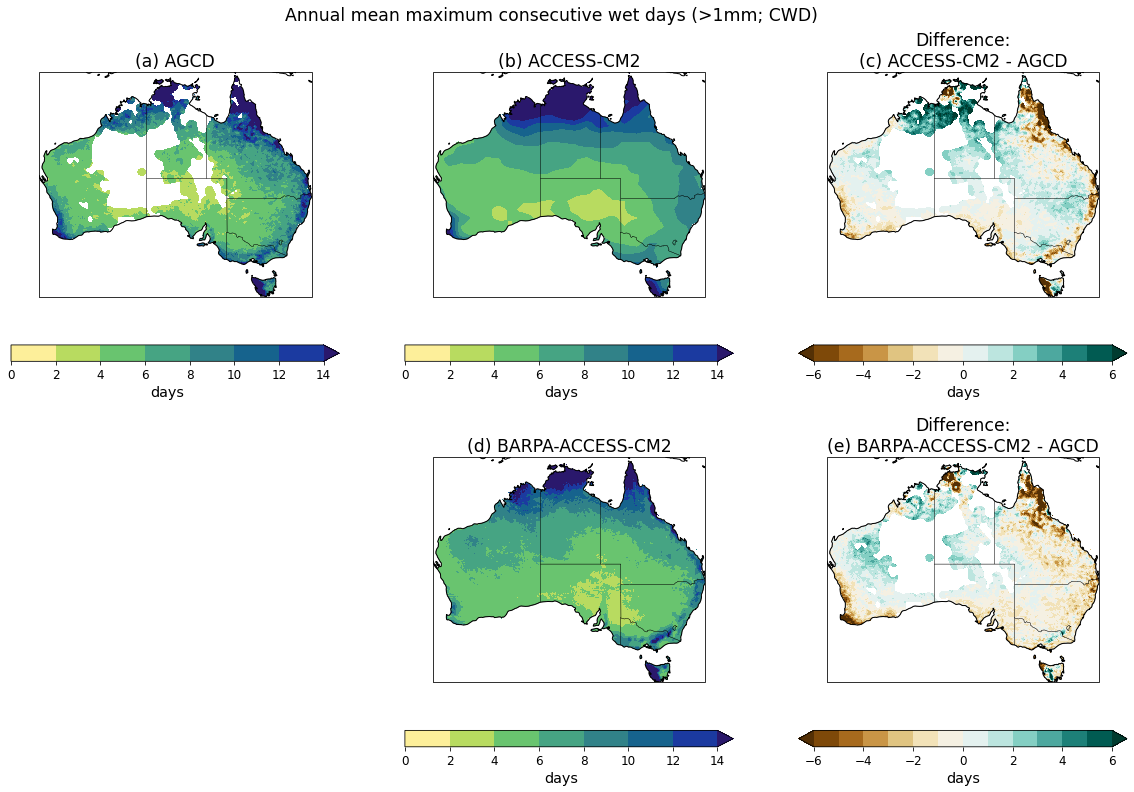

In [13]:
plot_index(
    'pr',
    'CWD',
    [0, 2, 4, 6, 8, 10, 12, 14],
    [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6],
    agcd_mask=da_mask,
)